# Boolean function identification problem
In this example, we aim to identify a Boolean function $f$ from the given binary input-ouput data such that the function $f$ can produce the expected ouput given a certain input. This is a typical [symbolic regression](https://en.wikipedia.org/wiki/Symbolic_regression) problem:

> Symbolic regression is a type of regression analysis that searches the space of mathematical expressions to find the model that best fits a given dataset, both in terms of accuracy and simplicity.

which is most commonly solved with genetic programming and its variant, gene expression programming (GEP), presented here. 

Before continuing this example, you'd better first go through the two fundamental tutorials listed below to get familiar with GEP and *geppy*:
+ [Introduction to gene expression programming](https://geppy.readthedocs.io/en/latest/intro_GEP.html)
+ [Overview of geppy for Gene Expression Programming (GEP)](https://geppy.readthedocs.io/en/latest/overview.html)

To check the detailed documentation of each function/class in *geppy*, please refer to [library reference](https://geppy.readthedocs.io/en/latest/#library-reference).

# Synthetic dataset

For this simple task, we first choose a ground truth Boolean function $f$ to generate a dataset $D$. Supposing there are four possible inputs $a, b, c, d$, the dataset $D$ contains 16 data samples (input-ouput pairs) in total.

In [1]:
def f(a, b, c, d):
    """ The true model, which only involves three inputs on purpose."""
    return (a and d) or not c

In [2]:
import itertools

# generate the training set which contains all the 16 samples
X = []
Y = []
for a, b, c, d in itertools.product([True, False], repeat=4):
    X.append((a, b, c, d))
    Y.append(f(a, b, c, d))

# Creating the primitives set
The first step in GEP (or GP as well) is to specify the primitive set, which contains the elementary building blocks to formulate the model. For this Boolean function problem, no constant terminals are necessary. Instead, only the three Boolean logic operators and the four input terminals are needed.

In [3]:
import geppy as gep
import operator

pset = gep.PrimitiveSet('Main', input_names=['a', 'b', 'c', 'd'])
pset.add_function(operator.and_, 2)
pset.add_function(operator.or_, 2)
pset.add_function(operator.not_, 1)

# Create the individual and population
Our objective is to **maximize** the number of samples that are correctly predicted by the evolved model. That is, the fitness of an individual is evaluated by *number of hits*.
## Define the indiviudal class, a subclass of *gep.Chromosome*

In [4]:
from deap import creator, base, tools

creator.create("FitnessMax", base.Fitness, weights=(1,))  # to maximize the objective (fitness)
creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMax)

## Register the individual and population creation operations
In DEAP, it is recommended to register the operations used in evolution into a *toolbox* to make full use of DEAP functionality. The configuration of individuals in this problem is:
+ head length of each gene is 5
+ each chromosome (individual) is composed of two genes.
+ the linking function is chosen to be *OR*. In practice, we may need to try different linking functions.

Generally, more complicated problems require a larger head length and longer chromosomes formed with more genes.

In [5]:
h = 5   # head length
n_genes = 2   # number of genes in a chromosome
toolbox = base.Toolbox()
toolbox.register('gene_gen', gep.Gene, pset=pset, head_length=h)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=operator.or_)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_, pset=pset)

# Define the fitness evaluation function
In DEAP, the single objective optimization problem is just a special case of more general multiobjective ones. Since *geppy* is built on top of DEAP, it conforms to this convention. **Even if the fitness only contains one measure, keep in mind that DEAP stores it as an iterable.** 

Knowing that, you can understand why the evaluation function must return a tuple value (even if it is a 1-tuple). That's also why we set ``weights=(1,)`` when creating the ``FitnessMax`` class.

In [6]:
def evaluate(individual):
    """Evalute the fitness of an individual"""
    func = toolbox.compile(individual)  # a lambda function
    n_correct = 0
    for (a, b, c, d), y in zip(X, Y):
        prediction = func(a, b, c, d)
        if prediction == y:
            n_correct += 1
    return n_correct,

In [7]:
toolbox.register('evaluate', evaluate)

# Register genetic operators
Compared with GP and other genetic algorithms, GEP has its own set of genetic operators aside from common mutation and crossover. For details, please check the tutorial [Introduction to gene expression programming](https://geppy.readthedocs.io/en/latest/intro_GEP.html).

In the following code, the selection operator is ``tools.selRoulette`` provided by DEAP, while all other operators are specially designed for GEP in *geppy*.

In [8]:
toolbox.register('select', tools.selRoulette)
toolbox.register('mutate', gep.mutate_uniform, pset=pset, ind_pb=2 / (2 * h + 1))
toolbox.register('invert', gep.invert)
toolbox.register('is_Transpose', gep.is_transpose)
toolbox.register('ris_Transpose', gep.ris_transpose)
toolbox.register('gene_Transpose', gep.gene_transpose)
toolbox.register('crossover_one_point', gep.crossover_one_point)
toolbox.register('crossover_two_point', gep.crossover_two_point)
toolbox.register('crossover_gene', gep.crossover_gene)

# Statistics to be inspected
We often need to monitor of progress of an evolutionary program. DEAP offers two classes to handle the boring work of recording statistics. Details are presented in [Computing statistics](http://deap.readthedocs.io/en/master/tutorials/basic/part3.html). In the following, we are intereted in the average/standard deviation/min/max of all the individuals' fitness in each generation.

In [9]:
import numpy 

stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

# Launch evolution
We make use of *geppy*'s builtin algorithm ``gep_simple`` here to perform the standard GEP evolution. A special class from DEAP, `HallOfFame`, is adopted to store the best individuals ever found. Besides, it should be noted that in GEP [*elitism*](https://en.wikipedia.org/wiki/Genetic_algorithm#Elitism) is highly recommended because some genetic operators in GEP are destructive and may destroy the best individual we have evolved.

In [10]:
# this section is just for reproduction purpose since evolutionary algorithms all involve randomness
import random
random.seed(123)

In [11]:
# size of population and number of generations
n_pop = 50
n_gen = 50

pop = toolbox.population(n=n_pop)
hof = tools.HallOfFame(1)   # only record the best individual ever found in all generations

# start evolution
pop, log = gep.gep_simple(pop, toolbox, mutation_pb=0.9, inversion_pb=0.1, is_transposition_pb=0.1, ris_transposition_pb=0.1, 
                          gene_transposition_pb=0.1, crossover_1p_pb=0.4, crossover_2p_pb=0.2, crossover_gene_pb=0.1,
                          n_generations=n_gen, n_elites=2,
                          stats=stats, hall_of_fame=hof, verbose=True)

gen	nevals	avg 	std   	min	max
0  	50    	8.38	2.6145	2  	14 
1  	45    	9   	2.72764	2  	14 
2  	46    	9.66	2.38839	6  	14 
3  	46    	9.68	2.31897	5  	14 
4  	47    	9.62	2.39073	4  	14 
5  	46    	9.86	2.46585	2  	14 
6  	44    	9.92	2.18028	3  	14 
7  	44    	10.38	2.06775	6  	14 
8  	47    	10.28	2.61565	2  	14 
9  	46    	10.3 	2.50799	2  	14 
10 	46    	10.44	2.44262	3  	14 
11 	47    	11.28	2.0692 	8  	14 
12 	47    	10.8 	2.40832	6  	14 
13 	48    	10.96	2.51364	6  	14 
14 	47    	10.6 	2.71293	4  	14 
15 	42    	10.94	2.64129	6  	14 
16 	46    	11.2 	2.45764	6  	14 
17 	45    	10.52	2.64756	4  	14 
18 	47    	10.58	2.87117	6  	14 
19 	45    	10.72	2.66863	6  	14 
20 	46    	10.86	3.33473	2  	16 
21 	46    	11.08	3.09735	6  	16 
22 	47    	10.9 	3.11288	2  	16 
23 	47    	10.82	3.17295	2  	16 
24 	47    	10.12	3.38018	2  	16 
25 	47    	11.02	2.8035 	6  	16 
26 	46    	10.38	2.62214	6  	16 
27 	47    	10.12	3.51363	2  	16 
28 	47    	11.18	3.08344	2  	16 
29 	47    	11.72	3.0

As we can see, after 20 generations, the maximum fitness is 16. Remember that we only have 16 samples in total. Thus, it takes 20 generations to find a perfect model. Now let's print the best individual to investigate what we have found.

In [12]:
best = hof[0]
print(best)

or_(
	not_(c),
	and_(c, and_(and_(c, a), d))
)


The above output shows: 
+ the linking function is `or_`
+ the two genes encode two functions respectively: `not_(c)` and `and_(c, and_(and_(c, a), d))`

Since the gene has a head domain of length 5, the length of the tail is $5*(2-1)+1=6$. That is, the whole length of a gene is 11. If you are interested in the content of a gene, you can check it with `repr`. It is clearly demonstrated that in GEP though each gene has a fixed length, the expression tree (or sub-tree in a multigenic chromosome) translated from a gene can have various sizes.

In [13]:
# [optional] check the 11 primitives of each gene
print('- Content of the two genes: ')
for gene in best:
    print(repr(gene))
#[optional] we can also check the K-expression (only including primitives that are expressed) of a gene
print('- K-expression of the two genes')
for gene in best:
    print(gene.kexpression)

- Content of the two genes: 
<class 'geppy.core.entity.Gene'> [not_, c, and_, d, or_, d, a, b, a, d, c]
<class 'geppy.core.entity.Gene'> [and_, c, and_, and_, d, c, a, d, c, a, d]
- K-expression of the two genes
[not_, c]
[and_, c, and_, and_, d, c, a]


# *[Optional]* Post-processing: simplification and visualization
## Symbolic simplification of the final solution
After the GEP evolution finishes, we can get the best individual (i.e., the best solution) best. Sometimes, the expression of the individual may involve a lot of redundancies. For example, x∗x+3∗y−y+(10−2)/4 is just x∗x+2∗y+2. 
However, the GEP evolution cannot realize this fact and thus the result we get are generally not simplified. 

In this problem, the final solution *best* seems more complicated than the true function $f$. Thus, it would be quite helpful if we can get a simplified version of the model we found by removing all the redundancies for better comparison and verification.*geppy* has provided a convenient function `simplify()` to perform symbolic simplification of the individual (solution) by leveraging the `sympy` package.

In [14]:
symplified_best = gep.simplify(best)
print('Symplified best individual: ')
print(symplified_best)

Symplified best individual: 
~c | (a & d)


Clearly, after simplification the best individual evolved by GEP is just the ideal function $f$. More importantly, GEP can perform implicit variable (feature) selection effectively: though we provide it with four inputs, GEP only picks the three useful inputs `a, c, d`.

## Visualization
If you are interested in the expression tree corresponding to the individual, i.e., the genotype/phenotype system, *geppy* supports tree visualization by the `graph` and the `export_expression_tree` functions:

- `graph` only outputs the nodes and links information to describe the tree topology, with which you can render the tree with tools you like;
- `export_expression_tree` implements tree visualization with data generated by `graph` internally using the `graphviz` package. 

In [15]:
rename_labels = {'and_': '&', 'or_': '|', 'not_': '~'}   # we want use symbol labels instead of words in the tree graph
gep.export_expression_tree(best, rename_labels, 'data/bool_tree.png')

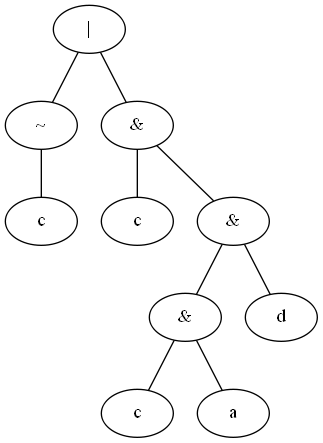

In [16]:
# show the above image here for convenience
from IPython.display import Image
Image(filename='data/bool_tree.png') 